In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

In [ ]:
# constants
heart_rate           = 2.483333                # beats per second
cardiac_output       = 0.0038                  # L/s
systemic_resistance  = 10317                   # mmHg s/L
pulmonary_resistance = 2 * 60                  # WU * 60 = mmHg s/L
compliance           = 0.0002601               # L/mmHg
angular_freq         = 2 * np.pi * heart_rate  # radians

# Python Simulation

In [ ]:
def blood_flow(t: float) -> float:
    # calculates the total blood flow at time t
    # for systemic, this function is sufficient
    # for pulmonary, needs to be split between resistor and capacitor in parallel
    return cardiac_output * np.sin(angular_freq * t)

def systemic_circulation(t: float) -> Tuple[float, float]:
    # calculates blood flow and pressure change through the SVR at time t
    blood_flow_total  = blood_flow(t)
    pressure_change   = blood_flow_total * systemic_resistance
    return blood_flow_total, pressure_change

def pulmonary_circulation(t: float) -> Tuple[float, float, float]:
    # calculates blood flow through the parallel PVR and compliance and pulmonary pressure change at time t
    pressure_change   = -blood_flow(t) / ((1/pulmonary_resistance) + (angular_freq * compliance))
    peak_pressure     = cardiac_output / ((1/pulmonary_resistance) + (angular_freq * compliance))
    peak_blood_flow_R = peak_pressure / pulmonary_resistance
    blood_flow_R      = -peak_blood_flow_R * np.sin(angular_freq * t)
    peak_blood_flow_C = peak_pressure * angular_freq * compliance
    blood_flow_C      = -peak_blood_flow_C * np.sin(angular_freq * t + np.pi/2)
    return blood_flow_R, blood_flow_C, pressure_change

In [ ]:
# simple tests to make sure blood flow calculations are correct
# total pulmonary should equal -systemic
blood_flow_systemic, P_systemic         = systemic_circulation(0.05)
blood_flow_R, blood_flow_C, P_pulmonary = pulmonary_circulation(0.05)

print(f"Systemic blood flow: {blood_flow_systemic}")
print(f"Pulmonary blood flow through Resistor: {blood_flow_R}; Capacitor: {blood_flow_C}")
print(f"Total pulmonary blood flow: {blood_flow_R + blood_flow_C}")

Systemic blood flow: 0.002672899587827862
Pulmonary blood flow through Resistor: -0.0017975013723405184; Capacitor: -0.0008846138858293902
Total pulmonary blood flow: -0.0026821152581699087


In [ ]:
# SIMULATION (for one value of PVR)
time                                    = np.arange(0, 3, 0.01)  # 3 seconds, sampled at 100 Hz
pulmonary_resistance                    = 20 * 60 # WU * 60 = mmHg s/L
blood_flow_systemic, P_systemic         = zip(*[systemic_circulation(t) for t in time])
blood_flow_R, blood_flow_C, P_pulmonary = zip(*[pulmonary_circulation(t) for t in time])

# convert blood flow to L/min
blood_flow_systemic = [blood_flow_systemic[i] * 60 for i in range(len(time))]
blood_flow_C        = [blood_flow_C[i] * 60 for i in range(len(time))]
blood_flow_R        = [blood_flow_R[i] * 60 for i in range(len(time))]

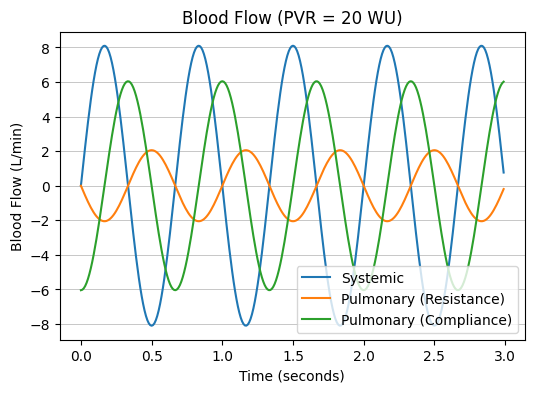

In [ ]:
# Blood Flow Plot
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(time, blood_flow_systemic, label="Systemic")
ax1.plot(time, blood_flow_R, label="Pulmonary (Resistance)")
ax1.plot(time, blood_flow_C, label="Pulmonary (Compliance)")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.set_title("Blood Flow (PVR = 20 WU)")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

In [ ]:
# calculate pressure changes for different values of PVR
test_values      = [0.2, 2, 5, 20]
pressure_changes = []

for val in test_values:
    pulmonary_resistance                    = val * 60 # WU * 60 = mmHg s/L
    blood_flow_R, blood_flow_C, P_pulmonary = zip(*[pulmonary_circulation(t) for t in time])
    pressure_changes.append(P_pulmonary)

In [ ]:
print(max(pressure_changes[0]))

1.5737068678437665


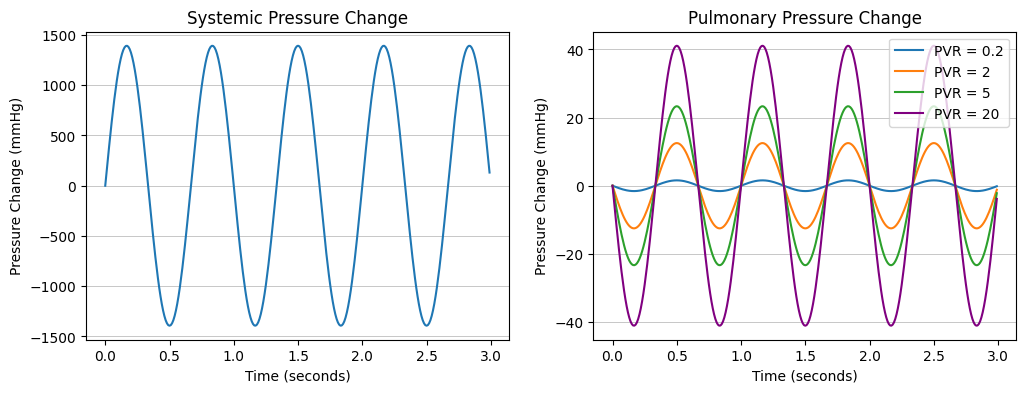

In [ ]:
# Pressure Change Plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

ax1.plot(time, P_systemic, label="Systemic Pressure Change")
ax1.set_title("Systemic Pressure Change")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Pressure Change (mmHg)")
ax1.grid(axis='y', linewidth = 0.5)

ax2.plot(time, pressure_changes[0], label="PVR = 0.2")
ax2.plot(time, pressure_changes[1], label="PVR = 2")
ax2.plot(time, pressure_changes[2], label="PVR = 5")
ax2.plot(time, pressure_changes[3], label="PVR = 20", color="purple")
ax2.set_title("Pulmonary Pressure Change")
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Pressure Change (mmHg)")
ax2.legend()
ax2.grid(axis='y', linewidth = 0.5)
plt.show()

In [ ]:
# peak blood flow and pressure based on PVR (range: 1-20 WU)
def peak_values_systemic() -> Tuple[float, float]:
    peak_blood_flow   = cardiac_output
    peak_pressure     = peak_blood_flow * systemic_resistance
    return peak_blood_flow, peak_pressure

def peak_values_pulmonary(R: float) -> Tuple[float, float, float]:
    peak_pressure     = cardiac_output / ((1/R) + (angular_freq * compliance))
    peak_blood_flow_R = peak_pressure / R
    peak_blood_flow_C = peak_pressure * angular_freq * compliance
    return peak_blood_flow_R, peak_blood_flow_C, peak_pressure

In [ ]:
PVR_range = range(1, 21)
peak_blood_flow_systemic, peak_pressure_systemic              = zip(*[peak_values_systemic() for R in PVR_range])
peak_blood_flow_R, peak_blood_flow_C, peak_pressure_pulmonary = zip(*[peak_values_pulmonary(R*60) for R in PVR_range])

# convert blood flow to L/min
peak_blood_flow_systemic = [peak_blood_flow_systemic[i] * 60 for i in range(len(PVR_range))]
peak_blood_flow_C        = [peak_blood_flow_C[i] * 60 for i in range(len(PVR_range))]
peak_blood_flow_R        = [peak_blood_flow_R[i] * 60 for i in range(len(PVR_range))]

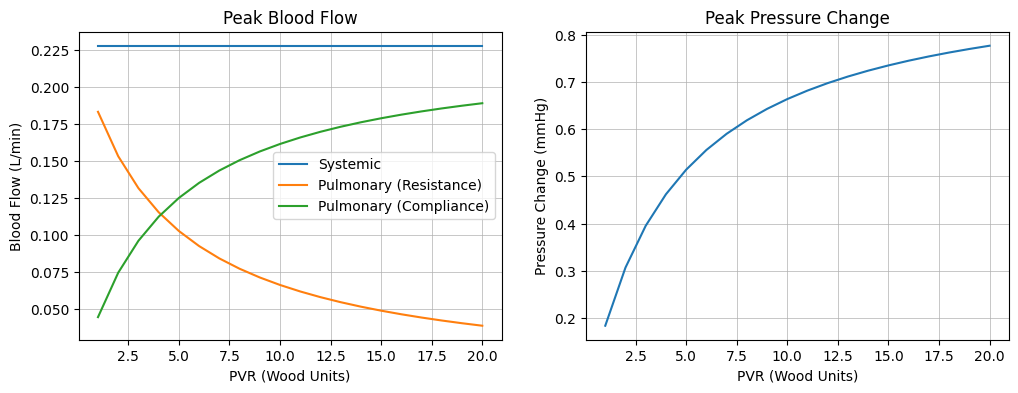

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

ax1.plot(PVR_range, peak_blood_flow_systemic, label="Systemic")
ax1.plot(PVR_range, peak_blood_flow_R, label="Pulmonary (Resistance)")
ax1.plot(PVR_range, peak_blood_flow_C, label="Pulmonary (Compliance)")
ax1.set_title("Peak Blood Flow")
ax1.set_xlabel("PVR (Wood Units)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.legend()
ax1.grid(linewidth = 0.5)

ax2.plot(PVR_range, peak_pressure_pulmonary, label="Peak Pressure Change")
ax2.set_title("Peak Pressure Change")
ax2.set_xlabel("PVR (Wood Units)")
ax2.set_ylabel("Pressure Change (mmHg)")
ax2.grid(linewidth = 0.5)
plt.show()

In [ ]:
for i in range(len(peak_blood_flow_R)):
    if peak_blood_flow_C[i] > peak_blood_flow_R[i]:
        print(f"Blood flow through compliance is higher when PVR is > {i} WU.")
        break

Blood flow through compliance is higher when PVR is > 4 WU.


In [ ]:
print(np.mean(peak_blood_flow_systemic))

0.22799999999999998


In [ ]:
print(peak_blood_flow_C)
print(peak_blood_flow_R)

[0.04464717928201155, 0.07467201313511075, 0.0962471276423084, 0.11249945985065564, 0.12518248106098828, 0.135355679243852, 0.14369697541026616, 0.15066030857846072, 0.15656108134647173, 0.16162526293016616, 0.16601898972096704, 0.1698671391723977, 0.17326538908808534, 0.17628828083617376, 0.17899475050575048, 0.18143200952244193, 0.18363832212200132, 0.18564502898739862, 0.18747804541842275, 0.18915898661675196]
[0.18335282071798847, 0.15332798686488922, 0.1317528723576916, 0.11550054014934437, 0.10281751893901171, 0.09264432075614801, 0.08430302458973384, 0.07733969142153929, 0.07143891865352826, 0.06637473706983386, 0.06198101027903296, 0.05813286082760229, 0.054734610911914706, 0.05171171916382626, 0.04900524949424949, 0.04656799047755807, 0.04436167787799871, 0.042354971012601356, 0.04052195458157725, 0.03884101338324804]


#Python Simulation with Pressure Fixed

In [ ]:
mpap                 = 20     # mmHg
pulmonary_resistance = 2 * 60 # WU * 60 = mmHg s/L

In [ ]:
def pulmonary_circulation_v2(t: float) -> Tuple[float, float, float]:
    # calculates blood flow through the parallel PVR and compliance and pulmonary pressure change at time t
    peak_blood_flow_R = mpap / pulmonary_resistance
    blood_flow_R      = -peak_blood_flow_R * np.sin(angular_freq * t)

    #peak_blood_flow_C = mpap * angular_freq * compliance
    blood_flow_C      = (-blood_flow(t)-blood_flow_R) * np.sin(angular_freq * t + np.pi/2)

    pressure_change   = (blood_flow_R+blood_flow_C) / ((1/pulmonary_resistance) + (angular_freq * compliance))

    return blood_flow_R, blood_flow_C, pressure_change

In [ ]:
print(f"Peak blood flow through PVR: {(mpap / pulmonary_resistance)*60} L/min")
print(f"Peak blood flow through capacitor: {mpap * angular_freq * compliance * 60} L/min")

Peak blood flow through PVR: 10.0 L/min
Peak blood flow through capacitor: 4.870083711521683 L/min


In [ ]:
# SIMULATION
blood_flow_R, blood_flow_C, P_pulmonary = zip(*[pulmonary_circulation_v2(t) for t in time])

# convert blood flow to L/min
blood_flow_C        = [blood_flow_C[i] * 60 for i in range(len(time))]
blood_flow_R        = [blood_flow_R[i] * 60 for i in range(len(time))]

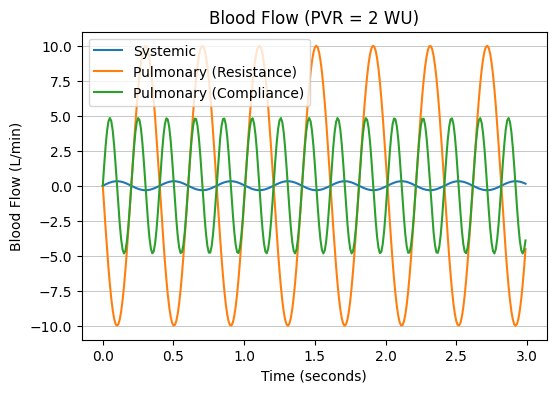

In [ ]:
# Blood Flow Plot
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(time, blood_flow_systemic, label="Systemic")
ax1.plot(time, blood_flow_R, label="Pulmonary (Resistance)")
ax1.plot(time, blood_flow_C, label="Pulmonary (Compliance)")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.set_title("Blood Flow (PVR = 2 WU)")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

# iCircuit Data Analysis

In [ ]:
# calculate input amplitude based on PVR
R   = 2 * 60
amp = (cardiac_output) / ((1/R) + (angular_freq * compliance))
print(amp)

0.30665597372977843


In [ ]:
df = pd.read_csv('data_compliance_x0.1.csv')[:257]

In [ ]:
# simple tests to make sure blood flow calculations are correct
# total pulmonary should equal -systemic
print(f"Systemic blood flow: {df['Systemic Resistance.I'][4]}")
print(f"Pulmonary blood flow through Resistor: {df['PVR.I'][4]}; Capacitor: {df['Compliance.I'][4]}")
print(f"Total pulmonary blood flow: {df['PVR.I'][4] + df['Compliance.I'][4]}")

Systemic blood flow: 0.0030273354314343
Pulmonary blood flow through Resistor: -0.000534192926793; Capacitor: -0.0024931425046413
Total pulmonary blood flow: -0.0030273354314343


In [ ]:
# convert blood flow to L/min
df['Systemic Resistance.I'] = df['Systemic Resistance.I'] * 60
df['PVR.I']                 = df['PVR.I'] * 60
df['Compliance.I']          = df['Compliance.I'] * 60

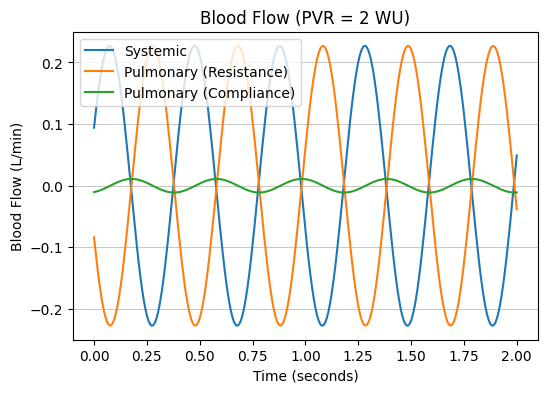

In [ ]:
# Blood Flow Plot
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(df['Time'], df['Systemic Resistance.I'], label="Systemic")
ax1.plot(df['Time'], df['PVR.I'], label="Pulmonary (Resistance)")
ax1.plot(df['Time'], df['Compliance.I'], label="Pulmonary (Compliance)")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.set_title("Blood Flow (PVR = 2 WU)")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

In [ ]:
# import pressure changes for different values of PVR
test_values          = [0.2, 2, 5, 20]
pressure_changes     = []
pressure_changes_sys = []

for val in test_values:
    filename = 'data_' + str(val) + 'WU.csv'
    df = pd.read_csv(filename)[:257]
    pressure_changes.append(df['PVR.Vd'])
    pressure_changes_sys.append(df['Systemic Resistance.Vd'])

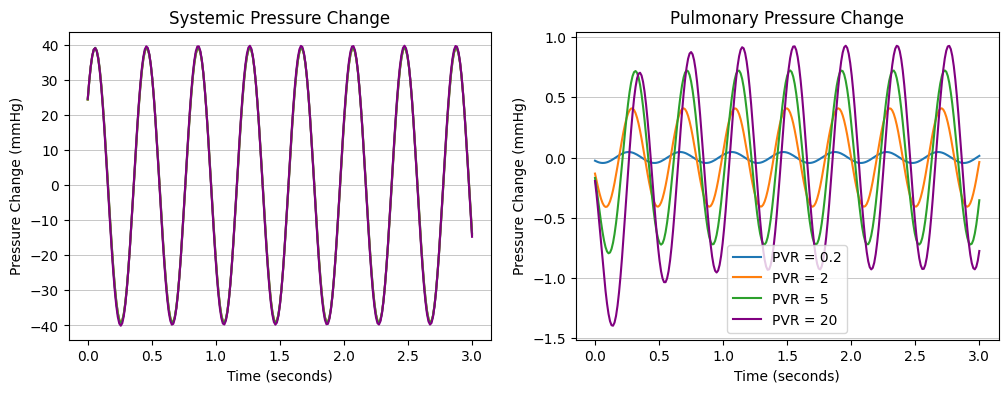

In [ ]:
# Pressure Change Plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

ax1.plot(df['Time'], pressure_changes_sys[0], label="PVR = 0.2")
ax1.plot(df['Time'], pressure_changes_sys[1], label="PVR = 2")
ax1.plot(df['Time'], pressure_changes_sys[2], label="PVR = 5")
ax1.plot(df['Time'], pressure_changes_sys[3], label="PVR = 20", color="purple")
ax1.set_title("Systemic Pressure Change")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Pressure Change (mmHg)")
ax1.grid(axis='y', linewidth = 0.5)

ax2.plot(df['Time'], pressure_changes[0], label="PVR = 0.2")
ax2.plot(df['Time'], pressure_changes[1], label="PVR = 2")
ax2.plot(df['Time'], pressure_changes[2], label="PVR = 5")
ax2.plot(df['Time'], pressure_changes[3], label="PVR = 20", color="purple")
ax2.set_title("Pulmonary Pressure Change")
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Pressure Change (mmHg)")
ax2.legend()
ax2.grid(axis='y', linewidth = 0.5)

plt.show()

In [ ]:
# peak blood flow and pressure based on PVR (range: 1-20 WU)
PVR_range                = range(1, 21)
peak_blood_flow_systemic = []
peak_blood_flow_R        = []
peak_blood_flow_C        = []
peak_pressure_pulmonary  = []

def peak(data) -> float:
    all_peaks = []
    for i in range(1, len(data)-1):
        if data[i] >= data[i-1] and data[i] >= data[i+1]:
            all_peaks.append(data[i])
    return np.mean(all_peaks)

for val in PVR_range:
    filename = 'data_' + str(val) + 'WU.csv'
    df = pd.read_csv(filename)[:257]
    peak_blood_flow_systemic.append(peak(df['Systemic Resistance.I'])*60)
    peak_blood_flow_R.append(peak(df['PVR.I'])*60)
    peak_blood_flow_C.append(peak(df['Compliance.I'])*60)
    peak_pressure_pulmonary.append(peak(df['PVR.Vd']))

In [ ]:
print(np.mean(peak_blood_flow_systemic))

0.22908891896956915


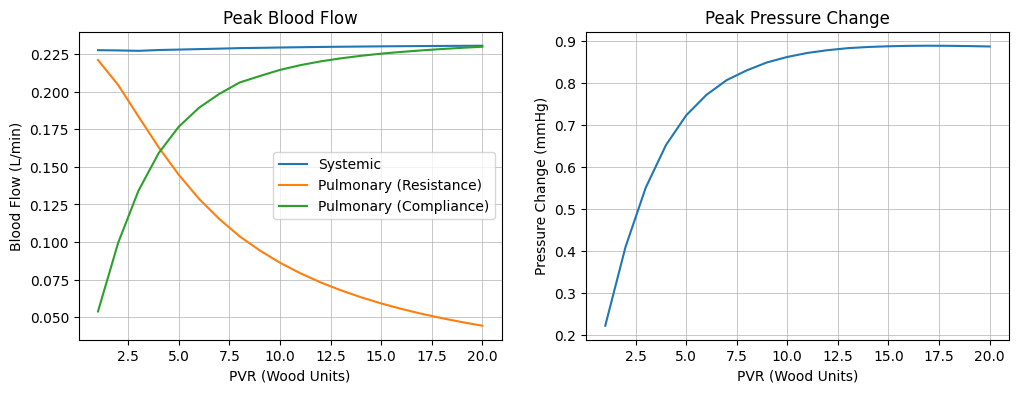

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

ax1.plot(PVR_range, peak_blood_flow_systemic, label="Systemic")
ax1.plot(PVR_range, peak_blood_flow_R, label="Pulmonary (Resistance)")
ax1.plot(PVR_range, peak_blood_flow_C, label="Pulmonary (Compliance)")
ax1.set_title("Peak Blood Flow")
ax1.set_xlabel("PVR (Wood Units)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.legend()
ax1.grid(linewidth = 0.5)

ax2.plot(PVR_range, peak_pressure_pulmonary, label="Peak Pressure Change")
ax2.set_title("Peak Pressure Change")
ax2.set_xlabel("PVR (Wood Units)")
ax2.set_ylabel("Pressure Change (mmHg)")
ax2.grid(linewidth = 0.5)
plt.show()

In [ ]:
# phase difference based on PVR
PVR_range             = range(1, 21)
phase_diff_PVR        = []
phase_diff_compliance = []

def first_peak(time, data) -> float:
    for i in range(1, len(data)):
        if data[i] >= data[i-1] and data[i] >= data[i+1]:
            return time[i]
        if data[i] <= data[i-1] and data[i] <= data[i+1]:
            return time[i]
    return -1.0

In [ ]:
for val in PVR_range:
    filename = 'data_' + str(val) + 'WU.csv'
    df = pd.read_csv(filename)[:257]
    # find t for the first peak for each of SVR, PVR, and compliance
    t_svr = first_peak(df['Time'], df['Systemic Resistance.I'])
    t_pvr = first_peak(df['Time'], df['PVR.I'])
    t_comp = first_peak(df['Time'], df['Compliance.I'])
    phase_diff_PVR.append(abs(t_pvr - t_svr))
    phase_diff_compliance.append(abs(t_comp - t_pvr))

In [ ]:
# phase difference - PYTHON MODEL
for val in PVR_range:
    pulmonary_resistance                    = val * 60 # WU * 60 = mmHg s/L
    blood_flow_systemic, P_systemic         = zip(*[systemic_circulation(t) for t in time])
    blood_flow_R, blood_flow_C, P_pulmonary = zip(*[pulmonary_circulation(t) for t in time])
    t_svr = first_peak(time, blood_flow_systemic)
    t_pvr = first_peak(time, blood_flow_R)
    t_comp = first_peak(time, blood_flow_C)
    phase_diff_PVR.append(abs(t_pvr - t_svr))
    phase_diff_compliance.append(abs(t_comp - t_pvr))

In [ ]:
print(phase_diff_PVR)
print(phase_diff_compliance)
print(f"Average phase difference between Systemic and Pulmonary Resistance: {np.mean(phase_diff_PVR)} seconds.")
print(f"Average phase difference between Pulmonary Resistance and Compliance: {np.mean(phase_diff_compliance)} seconds.")

[0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998, 0.19999999999999998]
[0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998]
Average phase difference between Systemic and Pulmonary Resistance: 0.2 seconds.
Average phase difference between Pulmonary Resistance and Compliance: 0.1 sec

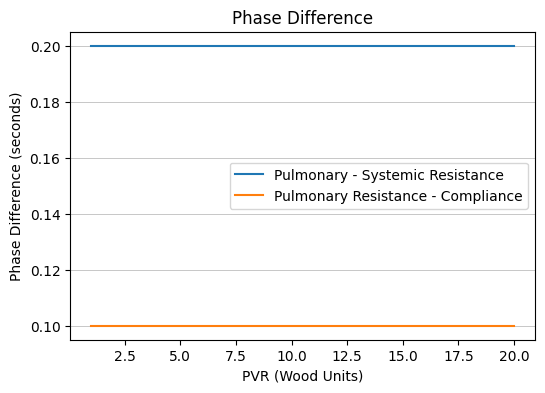

In [ ]:
# Phase difference plot
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(PVR_range, phase_diff_PVR, label="Pulmonary - Systemic Resistance")
ax1.plot(PVR_range, phase_diff_compliance, label="Pulmonary Resistance - Compliance")
ax1.set_xlabel("PVR (Wood Units)")
ax1.set_ylabel("Phase Difference (seconds)")
ax1.set_title("Phase Difference")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

In [ ]:
# Phase difference based on compliance
comp_range = ['0.1x normal', 'normal', '5x normal']
filenames = ['data_compliance_x0.1.csv', 'data_normal_compliance.csv', 'data_compliance_x5.csv']

for filename in filenames:
    df = pd.read_csv(filename)[:257]
    # find t for the first peak for each of SVR, PVR, and compliance
    t_svr = first_peak(df['Time'], df['Systemic Resistance.I'])
    t_pvr = first_peak(df['Time'], df['PVR.I'])
    t_comp = first_peak(df['Time'], df['Compliance.I'])
    phase_diff_PVR.append(abs(t_pvr - t_svr))
    phase_diff_compliance.append(abs(t_comp - t_pvr))

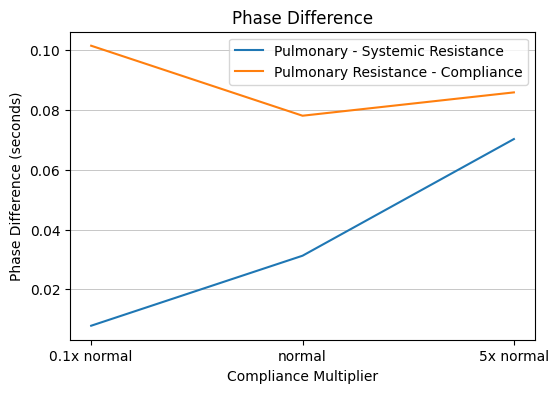

In [ ]:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(comp_range, phase_diff_PVR, label="Pulmonary - Systemic Resistance")
ax1.plot(comp_range, phase_diff_compliance, label="Pulmonary Resistance - Compliance")
ax1.set_xlabel("Compliance Multiplier")
ax1.set_ylabel("Phase Difference (seconds)")
ax1.set_title("Phase Difference")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

# Circuit with Pressure Fixed

In [ ]:
df = pd.read_csv('data_fixedpressure_2WU.csv')[:257]

# simple tests to make sure blood flow calculations are correct
# total pulmonary should equal -systemic
print(f"Systemic blood flow: {df['Systemic Resistance.I'][4]}")
print(f"Pulmonary blood flow through Resistor: {df['PVR.I'][4]}; Capacitor: {df['Compliance.I'][4]}")
print(f"Total pulmonary blood flow: {df['PVR.I'][4] + df['Compliance.I'][4]}")

FileNotFoundError: [Errno 2] No such file or directory: 'data_fixedpressure_20WU.csv'

In [ ]:
# convert blood flow to L/min
df['Systemic Resistance.I'] = df['Systemic Resistance.I'] * 60
df['PVR.I']                 = df['PVR.I'] * 60
df['Compliance.I']          = df['Compliance.I'] * 60

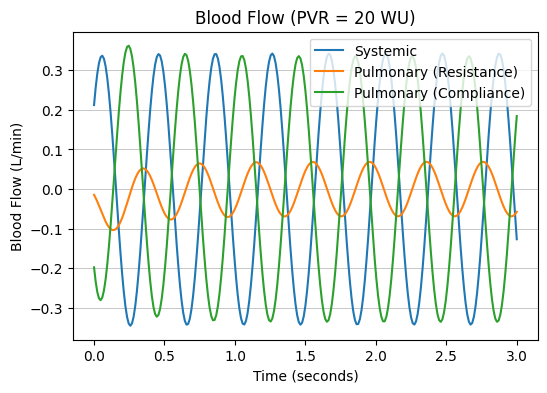

In [ ]:
# Blood Flow Plot
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(df['Time'], df['Systemic Resistance.I'], label="Systemic")
ax1.plot(df['Time'], df['PVR.I'], label="Pulmonary (Resistance)")
ax1.plot(df['Time'], df['Compliance.I'], label="Pulmonary (Compliance)")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Blood Flow (L/min)")
ax1.set_title("Blood Flow (PVR = 2 WU)")
ax1.legend()
plt.grid(axis='y', linewidth = 0.5)
plt.show()

In [ ]:
# import pressure changes for different values of PVR
test_values      = [0.2, 2, 5, 20]
pressure_changes = []

for val in test_values:
    filename = 'data_fixedpressure_' + str(val) + 'WU.csv'
    df = pd.read_csv(filename)[:257]
    pressure_changes.append(df['PVR.Vd'])

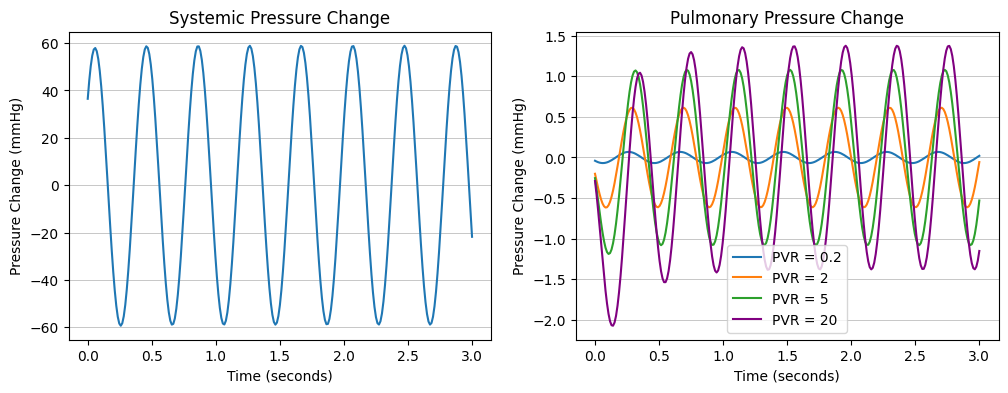

In [ ]:
# Pressure Change Plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

ax1.plot(df['Time'], df['Systemic Resistance.Vd'], label="Systemic Pressure Change")
ax1.set_title("Systemic Pressure Change")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Pressure Change (mmHg)")
ax1.grid(axis='y', linewidth = 0.5)

ax2.plot(df['Time'], pressure_changes[0], label="PVR = 0.2")
ax2.plot(df['Time'], pressure_changes[1], label="PVR = 2")
ax2.plot(df['Time'], pressure_changes[2], label="PVR = 5")
ax2.plot(df['Time'], pressure_changes[3], label="PVR = 20", color="purple")
ax2.set_title("Pulmonary Pressure Change")
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Pressure Change (mmHg)")
ax2.legend()
ax2.grid(axis='y', linewidth = 0.5)
plt.show()